In [4]:
from platform import python_version
import os 
import pandas as pd
import cv2 as cv2
import albumentations 
from fastai.vision.all import *
from skimage import morphology, graph
from skan import Skeleton
from skan.draw import overlay_skeleton_2d

print(python_version())
import torch
print( torch.cuda.is_available())
print( torch.cuda.get_device_name(0) )
print(torch.__version__)
import fastai
print(fastai.__version__)


3.8.16
True
NVIDIA GeForce GTX 1070
1.10.1+cu102
2.7.12


In [3]:
# specify path to training images, make copy in case needs resizing

path = Path('./train_enhancerGFP/')

path_img = path/'images'
path_anno = path/'labels'

fnames = get_image_files(path_img)
anno_names = get_image_files(path_anno)

In [5]:
#making sure all images are same size

for i in fnames:
    #img = cv2.imread(str(i), cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(str(i), cv2.IMREAD_COLOR)
    #plt.imshow(img)
    resized = cv2.resize(img, (693,512), interpolation = cv2.INTER_AREA)
    #plt.imshow(resized)
    cv2.imwrite(filename= str(i) , img=resized)
    
for i in anno_names:
    img = cv2.imread(str(i), cv2.IMREAD_GRAYSCALE)
    #plt.imshow(img)
    resized = cv2.resize(img, (693,512), interpolation = cv2.INTER_AREA)
    #plt.imshow(resized)
    cv2.imwrite(filename= str(i) , img=resized)



In [6]:
# masks for training model should be 0 and 255.0

for i in anno_names:
    img = cv2.imread(str(i), cv2.IMREAD_GRAYSCALE)
    #plt.imshow(img)
    rescaled = (255.0 / img.max() * (img - img.min())).astype(np.uint8)
    rescaled = rescaled / 255.0
    rescaled = rescaled.astype(np.uint8)
    #plt.imshow(resized)
    cv2.imwrite(filename= str(i) , img=rescaled)

In [7]:
# create augmentations; just run once..

labeller = lambda x: path/f'labels/{x.stem}{x.suffix}'

def labeller_aug(x,k):
    return path/f'images/{x.stem}_AUG{k}_{x.suffix}'

def labeller_aug_msk(x,k):
    return path/f'labels/{x.stem}_AUG{k}_{x.suffix}'


class SegmentationAlbumentationsTransform(ItemTransform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])


def get_train_aug(): return albumentations.Compose([
    #albumentations.Transpose(p=0.5),
    #albumentations.VerticalFlip(p=0.5),
    albumentations.Affine(scale=(0.8,1.2), rotate=(-70,70),shear=(-10,10), p=1) ,
    albumentations.Perspective(p=0.5, scale=(0,0.1)),
    albumentations.RandomBrightnessContrast( brightness_limit=(-0.7,0.05), contrast_limit=(0.8,1.2), p=1),
    albumentations.CoarseDropout( p=0.8, min_holes=3, max_holes=8,max_height=10, max_width=10 )
])    


tfm = SegmentationAlbumentationsTransform(get_train_aug())

for j in range(len(fnames)):
    i = fnames[j]
    img = PILImage.create(i)
    mask = PILMask.create(labeller(i))
    #ax = img.show()
    #ax = mask.show(ctx=ax)

    for h in range(30):
        a,b = tfm((img, mask))
        #ax = a.show()
        #ax = b.show(ctx=ax)
        a.save( labeller_aug(i,h)     )
        b.save( labeller_aug_msk(i,h) )


In [8]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

744
['background' 'enhancer']


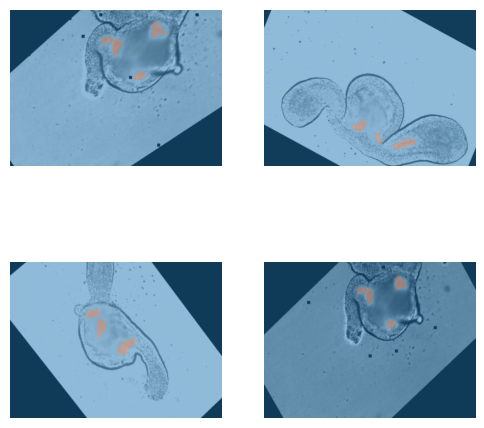

In [9]:
path = Path('./train_enhancerGFP/')

files = get_image_files(path/'images')
print(len(files))

codes = np.loadtxt(path/'codes.txt', dtype='str')
print(codes)

def labeller(x):
    return path/f'labels/{x.stem}{x.suffix}'


db = DataBlock(blocks=(ImageBlock(cls=PILImageBW), MaskBlock(codes=codes)),
               #batch_tfms=tfms,
               splitter=RandomSplitter(valid_pct=0.2, seed=42),
               item_tfms=[Resize((378,512))],
               get_items=get_image_files,
               get_y=labeller,batch_tfms=[Resize((378,512)), Normalize.from_stats(*imagenet_stats)])

dls = db.dataloaders(source=path_img, bs=4, drop_last=True)

dls.show_batch()



In [10]:
dls.vocab = codes

name2id = {v:k for k,v in enumerate(codes)}

void_code = name2id['background']

def acc_semseg(inp, targ): #from https://walkwithfastai.com/Segmentation
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [11]:
opt = ranger
learn = unet_learner(dls, arch=resnet34, metrics=acc_semseg, self_attention=True, act_cls=Mish, opt_func=opt)

learn.summary()


DynamicUnet (Input shape: 4 x 3 x 378 x 512)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 64 x 189 x 256  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     4 x 64 x 95 x 128   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

SuggestedLRs(valley=0.00010964782268274575)

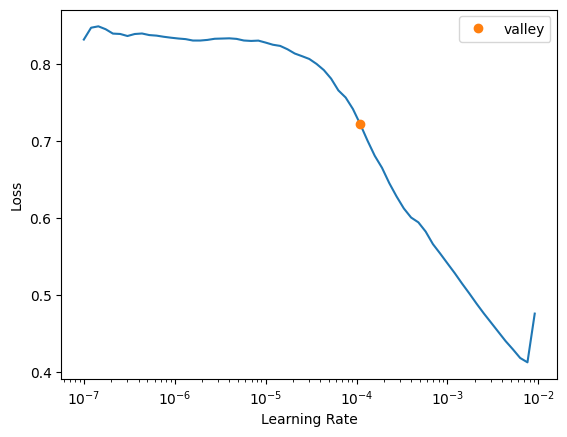

In [12]:
learn.lr_find()

In [13]:
lr = 1e-4
learn.fit_flat_cos(10, slice(lr))

epoch,train_loss,valid_loss,acc_semseg,time
0,0.040425,0.020331,0.501065,01:48
1,0.017544,0.017314,0.396371,01:49
2,0.014180,0.014441,0.642609,01:51
3,0.010978,0.012703,0.677973,01:52
4,0.009434,0.011280,0.732774,01:53
5,0.008352,0.010834,0.735790,01:53
6,0.007209,0.011458,0.717823,01:53
7,0.006371,0.010754,0.780436,01:54
8,0.005398,0.010403,0.776308,01:53
9,0.004499,0.010962,0.761911,01:54


In [14]:
learn.save('GFP_stage-1')
learn.load('GFP_stage-1');

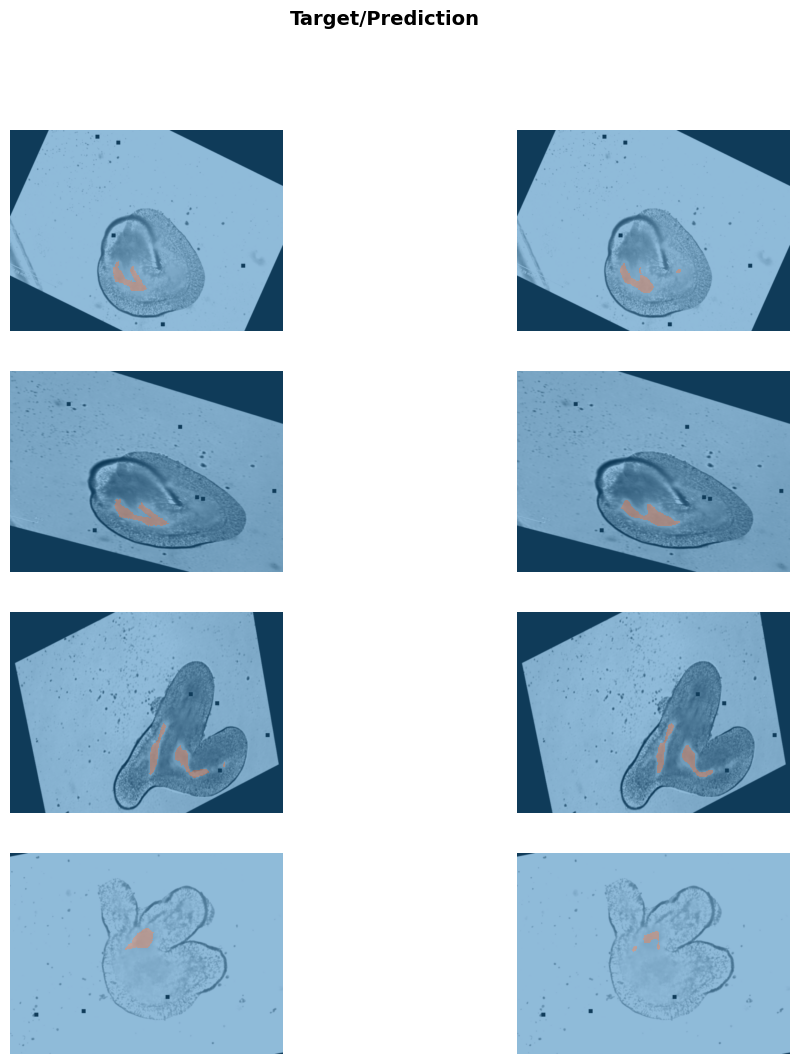

In [15]:
learn.show_results(max_n=4, figsize=(12,12))

In [16]:
lrs = slice(lr/400, lr/4)


In [17]:
lr, lrs

(0.0001, slice(2.5e-07, 2.5e-05, None))

In [18]:
learn.unfreeze()



In [19]:
learn.fit_flat_cos(15, lrs)


epoch,train_loss,valid_loss,acc_semseg,time
0,0.004523,0.011210,0.753109,01:59
1,0.004449,0.010953,0.776959,01:59
2,0.004217,0.011257,0.757886,01:59
3,0.003922,0.011858,0.747638,01:59
4,0.003836,0.011295,0.771888,01:59
5,0.003807,0.011618,0.764945,01:59
6,0.003576,0.012345,0.737795,02:00
7,0.003507,0.011885,0.773487,01:59
8,0.003394,0.012044,0.776249,02:01
9,0.003284,0.011760,0.809706,02:01


In [20]:
learn.save('GFP_model_1')

learn.load('GFP_model_1')



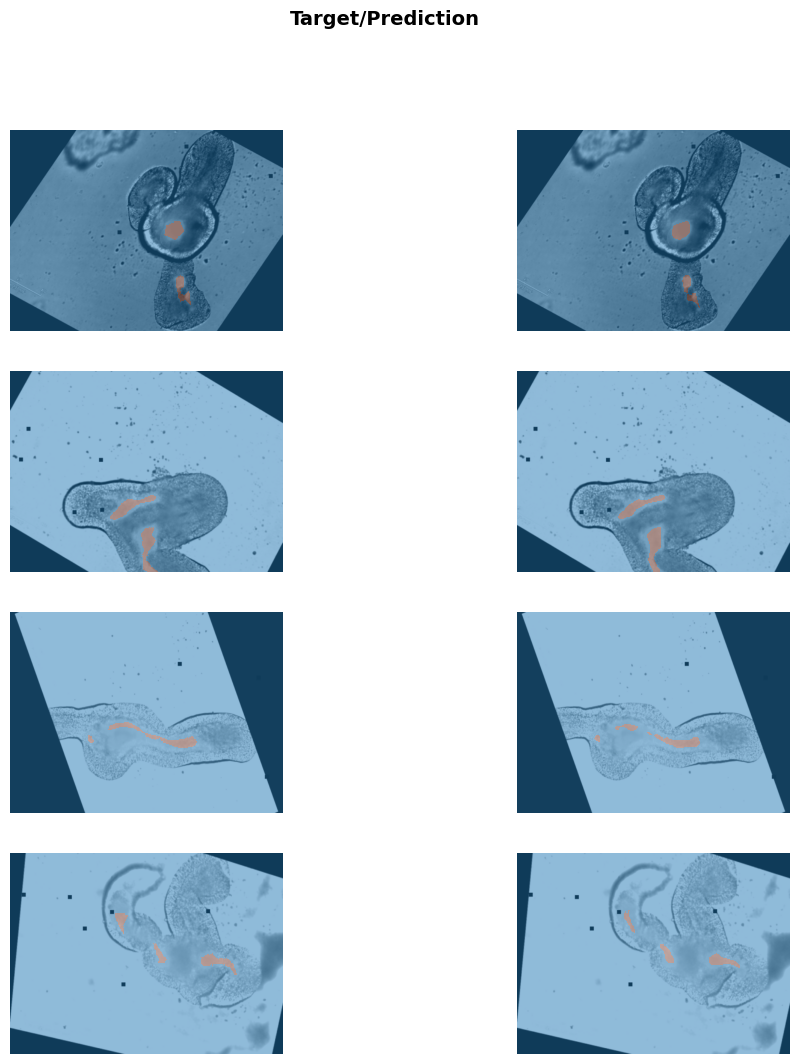

In [21]:
learn.show_results(max_n=4, figsize=(12,12))


In [22]:
learn.export('GFP_model_1_export.pkl')
